In [2]:
import os
os.environ['CUDA_VISIBLE_DEVICES'] = '0'

In [3]:
# Import standard modules
import numpy as np
import h5py
import matplotlib.pyplot as plt
plt.set_cmap('jet')
import os
import pickle

<Figure size 432x288 with 0 Axes>

In [4]:
# Import torch modules
import torch
from torch import FloatTensor, cat, from_numpy
from torch.autograd import Variable
from torchsummary import summary

In [5]:
import sys
sys.path.append('../src/')

In [6]:
# Import transform net
from model_transform_net import ModelTransformNet

In [7]:
# Import utils function
from utils import dot_dict, load_model, gram_matrix

#### 1. Specify options

In [8]:
device = 'cuda'

In [9]:
data_dir = './data/'

In [21]:
args = {}
args['m_pca'] = os.path.join(data_dir, 'm_pca_test200_case2.h5')         # New PCA models
args['m_petrel'] = os.path.join(data_dir, 'm_petrel_train3000_case2.h5')         # New PCA models
args['save_model'] = './weights/fw_weights_case2_sw50.0_rw500.0_hw10.0_9ep.pth' 
args = dot_dict(args)

#### 2. Load data

In [22]:
# Load m_pca
m_pca = load_model(args.m_pca).astype(np.float32)
m_pca = m_pca.transpose((0, -1, 1,2,3))
m_pca.shape

(200, 1, 40, 60, 60)

In [23]:
# Normalize data
max_, min_ = 2., 0.
m_pca = (m_pca - min_) / (max_ - min_) * 255.

#### 3. Construct Transform Net

In [24]:
trans_net = ModelTransformNet()
trans_net = trans_net.to(device)
summary(trans_net, input_size=(1, 40, 60, 60), device=device)

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
      CirularPad3d-1        [-1, 1, 42, 68, 68]               0
            Conv3d-2       [-1, 32, 40, 60, 60]           7,808
         ConvLayer-3       [-1, 32, 40, 60, 60]               0
       BatchNorm3d-4       [-1, 32, 40, 60, 60]              64
              ReLU-5       [-1, 32, 40, 60, 60]               0
      CirularPad3d-6       [-1, 32, 42, 62, 62]               0
            Conv3d-7       [-1, 64, 20, 30, 30]          55,360
         ConvLayer-8       [-1, 64, 20, 30, 30]               0
       BatchNorm3d-9       [-1, 64, 20, 30, 30]             128
             ReLU-10       [-1, 64, 20, 30, 30]               0
     CirularPad3d-11       [-1, 64, 22, 32, 32]               0
           Conv3d-12      [-1, 128, 20, 15, 15]         221,312
        ConvLayer-13      [-1, 128, 20, 15, 15]               0
      BatchNorm3d-14      [-1, 128, 20,

#### 4. Load Weights

In [25]:
trans_net.load_state_dict(torch.load(args.save_model, map_location=torch.device(device)))
trans_net.eval()
print('')

#### 5. Evaluate on Test PCA Models

In [26]:
num_model = m_pca.shape[0]

In [28]:
batch_size = 4
num_batch = num_model // batch_size
fw_m_pca = np.zeros_like(m_pca)

In [29]:
for ib in range(num_batch):
    ind0 = ib * batch_size
    ind1 = ind0 + batch_size
    data = m_pca[ind0:ind1, ...]
    fw_m_pca[ind0:ind1, ...] = trans_net(Variable(torch.from_numpy(data).float()).to(device)).data.cpu().numpy()

#### 6. Histogram Transform to Match Facies Fraction

In [31]:
# Load m_petrel
m_petrel = load_model(args.m_petrel).astype(np.float32)
m_petrel = m_petrel.transpose((0, -1, 1,2,3))
m_petrel.shape

(3000, 1, 40, 60, 60)

In [32]:
bins = 200
hist, bins_target = np.histogram(m_petrel.flatten(), bins)
cdf_target = hist.cumsum()
cdf_target = cdf_target / cdf_target.max()
cdf_target = np.concatenate(([0], cdf_target))

In [33]:
def hist_trans(data, cdf_target, bins_target, bins):
    hist, bins = np.histogram(data.flatten(), bins)
    cdf = hist.cumsum()
    cdf = cdf / cdf.max()
    cdf = np.concatenate(([0], cdf))
    # Histogram transformation
    cdf_values = np.interp(data.flatten(), bins, cdf)
    data_ht = np.interp(cdf_values, cdf_target, bins_target)
    data_ht = data_ht.reshape(data.shape)
    return data_ht

In [34]:
batch_size = 20
num_batch = num_model // batch_size
m_cnnpca = np.zeros_like(fw_m_pca)
for ib in range(num_batch):
    ind0 = ib * batch_size
    ind1 = ind0 + batch_size
    data = fw_m_pca[ind0:ind1, ...]
    m_cnnpca[ind0:ind1, ...] = hist_trans(data, cdf_target, bins_target, bins)

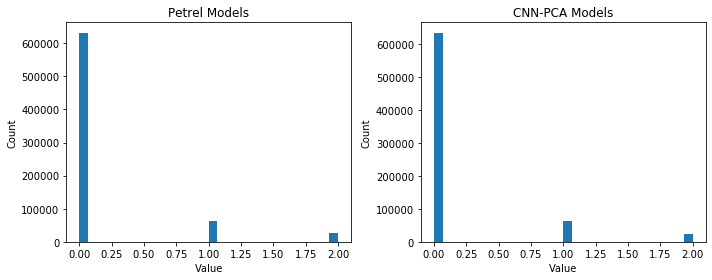

In [35]:
plt.figure(figsize=(10,4))
plt.subplot(1,2,1)
plt.hist(m_petrel[:5, ...].flatten(),30)
plt.xlabel("Value")
plt.ylabel("Count")
plt.title("Petrel Models")
plt.subplot(1,2,2)
plt.hist(m_cnnpca[:5, ...].flatten(),30)
plt.xlabel("Value")
plt.ylabel("Count")
plt.title("CNN-PCA Models")
plt.tight_layout()
plt.show()

In [40]:
### Switch chan and levee
def switch(data):
    data[np.where(data==2.0)] = 3.0
    data[np.where(data==1.0)] = 2.0
    data[np.where(data==3.0)] = 1.0
    return data

In [43]:
# Switch to mud-0, levee-1 and channel-2 for plotting
m_petrel = switch(m_petrel)
m_cnnpca = switch(np.round(m_cnnpca).astype(int))

In [44]:
# Define well locations
well_loc = [(12, 12), (28, 3), (4, 26), (48, 48), (58, 31), (32, 57)]
well_names = [ 'I1', 'I2', 'I3', 'P1', 'P2', 'P3']

In [45]:
def plot_wells(c='k'):
    for wl, wn in zip(well_loc, well_names):
        plt.plot(wl[0]-1, wl[1]-1, c+'.', markersize=20)
        plt.text(wl[0]+2, wl[1]+2, wn, color=c, fontsize=20)

Model 0


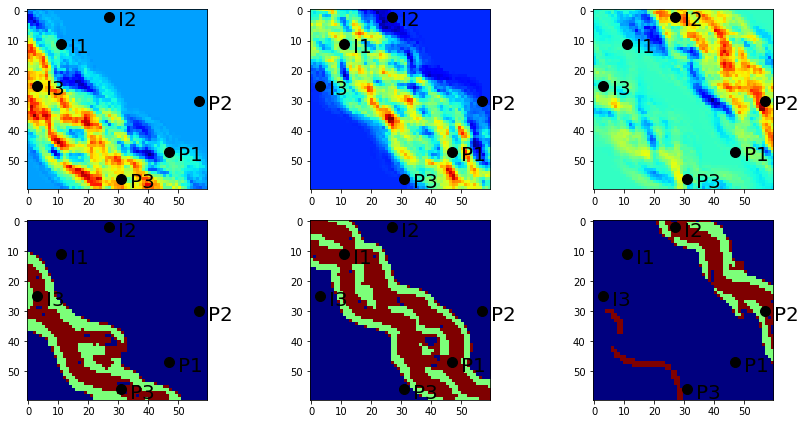

Model 1


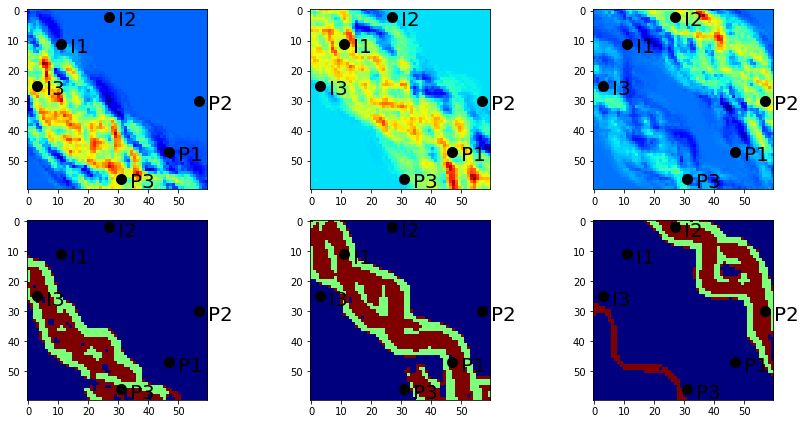

In [47]:
layers = [0, 15, 25]
nz = len(layers)
for k in range(2):
    print('Model', k)
    plt.figure(figsize=(12,6))
    for ind, z in enumerate(layers):
        plt.subplot(2,nz,ind+1)
        plt.imshow(m_pca[k, 0, z, :, :].astype('double'))
        plot_wells()
#         plt.clim([0,255])
        plt.subplot(2,nz,ind+nz+1)
        plt.imshow(m_cnnpca[k, 0, z, :, :].astype('double'))
        plot_wells()
#         plt.clim([0,255])
    plt.tight_layout()
    plt.show()
        

In [ ]:
# Save CNN-PCA Models
fid = h5py.File(os.path.join(data_dir,'m_cnnpca_test200_case2.h5'), 'w')
fid.create_dataset('data', data=m_cnnpca)
fid.close()

In [71]:
exit()